# **Resnet18 (Pytorch-Ligthning)**
Andrey Duvan Rincon Torres

---

In [ ]:
pip install pytorch-lightning

In [ ]:
pip install pyyaml==5.4.1

In [ ]:
pip install plotly_express

In [ ]:
# Librerias Nesesarias
import torch
import pandas as pd
import plotly.express as plx
import numpy as np
from torch import nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchmetrics.functional import accuracy
from sklearn.model_selection import train_test_split
import os
AVAIL_GPUS = min(1, torch.cuda.device_count())
# Imagenes
import torchvision
from torchvision import datasets, models, transforms
# Extraer zip
!unzip hymenoptera_data.zip

# **Los Datos**

In [42]:
# Transformacion para las imagenes
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # Recorta una parte aleatoria de la imagen y cambia su tamaño a un tamaño determinado.
        transforms.RandomHorizontalFlip(), # Voltea horizontalmente la imagen dada al azar
        transforms.ToTensor(), # Transformar en tensores
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizar imagenes
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), # Re escalar imagen
        transforms.CenterCrop(224), # Recortar desde el centro
        transforms.ToTensor(), # Transformar en tensores
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalizar imagenes
    ]),
}

In [47]:
data_dir = 'hymenoptera_data'
# Leer los directorios de las imagenes
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'val']}
# Crear iterable sobre las imagenes en las carpetas
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
# Tamaños de las imagenes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Niveles de las imagenes
class_names = image_datasets['train'].classes
# Usar o no GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


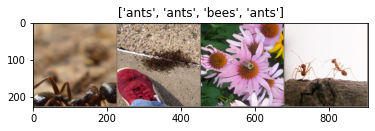

In [52]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # mini pausa para que cargen bien
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [58]:
inputs.shape

torch.Size([4, 3, 224, 224])

# **Modelo**

In [59]:
# CArgar un modelo pre entrenado
model_ft = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model_ft.

In [ ]:
# Modelo de regresion
class Model_Autocoder(nn.Module):
  # creamos la estructura de la red
  def __init__(self):
    super(Model_Autocoder,self).__init__()
    # {Encoder} ---------------------------------------------------------------#
    self.Conv_1e = torch.nn.Conv2d(in_channels = 1, out_channels = 64, 
                                  kernel_size = 2, stride = 2, padding = 0)
    self.Dropout_1e = torch.nn.Dropout(0.2)
    self.Conv_2e = torch.nn.Conv2d(in_channels = 64, out_channels = 128, 
                                  kernel_size = 2, stride = 2, padding = 0)
    self.Dropout_2e = torch.nn.Dropout(0.2)
    self.Conv_3e = torch.nn.Conv2d(in_channels = 128, out_channels = 256, 
                                  kernel_size = 2, stride = 2, padding = 0)
    self.Dropout_3e = torch.nn.Dropout(0.2)
    self.flate = nn.Flatten()
    self.Dropout_4e = torch.nn.Dropout(0.2)
    self.layer_1e = torch.nn.Linear(4096, 512)
    # {Decoder} ---------------------------------------------------------------#
    self.layer_1d = torch.nn.Linear(512, 4096)
    self.Conv_3d = torch.nn.ConvTranspose2d(in_channels = 256, out_channels = 128, 
                                           kernel_size = 2, stride = 2, 
                                           padding = 0)
    self.Dropout_3d = torch.nn.Dropout(0.2)   
    self.Conv_2d = torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, 
                                  kernel_size = 2, stride = 2, padding = 0)
    self.Dropout_2d = torch.nn.Dropout(0.2)
    self.Conv_1d = torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 3, 
                                  kernel_size = 2, stride = 2, padding = 0)
    self.Dropout_1d = torch.nn.Dropout(0.2)
    # Definimos el comportamiento de las capas
  def forward(self, x):
    batch_size, channels, width, height = x.size()
    # {Encoder} -------------------------------------------------------------#
    # Conv2D
    out = self.Conv_1e(x) # (16x16x64)
    out = self.Dropout_1e(torch.relu(out))
    out = self.Conv_2e(out) # (8x8x128)
    out = self.Dropout_2e(torch.relu(out))
    out = self.Conv_3e(out) # (4x4x256)
    out = self.Dropout_3e(torch.relu(out))
    # Capa lineal
    out = self.flate(out)
    out = self.Dropout_4e(out)
    out = self.layer_1e(out)
    # {Decoder} -------------------------------------------------------------#
    # Capa lineal
    out = self.layer_1d(out)
    out = torch.reshape(out, (batch_size,256,4,4))
    # Conv2D
    out = self.Conv_3d(out) # (4x4x256)
    out = self.Dropout_3d(torch.relu(out))
    out = self.Conv_2d(out) # (8x8x128)
    out = self.Dropout_2d(torch.relu(out))
    out = self.Conv_1d(out) # (16x16x64)
    out = self.Dropout_1d(torch.relu(out))
    # {Salida} --------------------------------------------------------------#
    return out

# **Clase de los datos**

In [ ]:
# Clase de los datos
class DataModule(pl.LightningDataModule):
    # Definimos un tamaño de lote en la calse
    def __init__(self, x_train, y_train, x_test, y_test, batch_size = 32):
        super(DataModule,self).__init__()
        self.batch_size = batch_size
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
    # Definimos la funcion que transforma los datos
    def transform(self, x):
        x_norm = x.astype('float32') / 255.
        return x_norm
    # Definimos el tratamiento de los datos
    def setup(self, stage=None):
        # Aplicamos las tranformaciones
        if stage == "fit" or stage is None:
          x = self.transform(self.x_train)
          y = self.transform(self.y_train)
          # Seleccionamos el conjunto de validacion
          x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.1, random_state = 0, shuffle = True)
          # Transformar en tensores
          self.train_dataset = TensorDataset(torch.tensor(x_train.astype(np.float32)),torch.tensor(y_train.astype(np.float32)))
          self.val_dataset = TensorDataset(torch.tensor(x_val.astype(np.float32)),torch.tensor(y_val.astype(np.float32)))
        if stage == "test" or stage is None:
          x = self.transform(self.x_test)
          y = self.transform(self.y_test)
          self.test_dataset = TensorDataset(torch.tensor(x.astype(np.float32)),torch.tensor(y.astype(np.float32)))
    # Iterable de entrenamiento
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)
    # Iterable de validacion
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)
    # Iterable de test
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

# **Entrenamiento**

In [ ]:
# Definimos modelo y proceso de entrenamiento
class Regression(pl.LightningModule):
  # creamos la estructura de la red
  def __init__(self, model):
    super().__init__()
    self.model = model
    # Paso de entrenamiento
  def training_step(self, batch, batch_idx):
    loss_mse,loss_mae = self._shared_eval_step(batch, batch_idx)
    self.log("train_mse", loss_mse, prog_bar=True)
    self.log("train_mae", loss_mae, prog_bar=True)
    return loss_mse
  # Paso de validacion
  def validation_step(self, batch, batch_idx):
    loss_mse,loss_mae = self._shared_eval_step(batch, batch_idx)
    self.log("val_mse", loss_mse, prog_bar=True)
    self.log("val_mae", loss_mae, prog_bar=True)
    return loss_mse
  # Paso de prueba
  def test_step(self, batch, batch_idx):
    loss_mse,loss_mae = self._shared_eval_step(batch, batch_idx)
    self.log("val_mse", loss_mse, prog_bar=True)
    self.log("val_mae", loss_mae, prog_bar=True)
    return loss_mse
  # Funcion para evaluar el modelo y la perdida
  def _shared_eval_step(self,batch,batch_idx):
    x, y  = batch
    y_hat = self.model(x)
    loss_mse = mse_loss(y_hat, y)
    loss_mae = mae_loss(y_hat, y)
    return loss_mse,loss_mae
  # Configuracion del optimizador
  def configure_optimizers(self):
    return torch.optim.Adam(self.model.parameters(), lr=0.02)

##  Ajustar el modelo

In [ ]:
data_module = DataModule(x_train = x_train_gray, y_train = x_train, x_test = x_test_gray, y_test = x_test, batch_size = 256) # Ejecutamos modulo de datos
model = Model_Autocoder() # Ejecutamos modelo
task = Regression(model) # Ejecutamos proceso de entrenamiento
trainer = pl.Trainer(max_epochs = 200, progress_bar_refresh_rate = 20) # Lamamos el entrenador
trainer.fit(task,data_module) # Entrenamos el modelo

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1815: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
Missing logger folder: /content/lightning_logs

  | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
trainer.test(task,data_module) # Test del modelo

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_mae            0.33825233578681946
        test_mse            0.17089520394802094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_mae': 0.33825233578681946, 'test_mse': 0.17089520394802094}]

In [ ]:
x, y = data_module.test_dataset
x_decoded = model.forward(x)

In [ ]:
img_rows = 32
img_cols = 32
channels = 3
# Imagenes a color
imgs_t = x_test[:100]
imgs_t = imgs_t.reshape((10, 10, img_rows, img_cols, channels))
imgs_t = np.vstack([np.hstack(i) for i in imgs_t])
# Imagenes blanco y negro
imgs_g = x_test_gray[:100]
imgs_g = imgs_g.reshape((10, 10, img_rows, img_cols))
imgs_g = np.vstack([np.hstack(i) for i in imgs_g])
# Imagenes coloreadas
imgs = x_decoded[:100]
imgs = imgs.reshape((10, 10, img_rows, img_cols, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,25))
plt.subplot(131)
plt.axis('off')
plt.title('Gray images')
plt.imshow(imgs_g, interpolation='none',cmap='gray')
plt.savefig('./test.png')

plt.subplot(132)
plt.axis('off')
plt.title('Colorized test images (Predicted)')
plt.imshow(imgs, interpolation='none')
plt.savefig('./colorized.png')

plt.subplot(133)
plt.axis('off')
plt.title('Test images')
plt.imshow(imgs_t, interpolation='none')
plt.savefig('./test.png')

plt.show()

In [ ]:
# Tablero de resultados
%load_ext tensorboard
%tensorboard --logdir lightning_logs/